# Wine analisys

This notebook containes some data analysis and ML insight into dataset about wines. The data set was taken from Kaggle and can be fount [here](https://www.kaggle.com/zynicide/wine-reviews).

In [10]:
import pandas as pd
from pathlib import Path
import os
import seaborn as sns
import math
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
import statsmodels.api as sm
from statsmodels.formula.api import ols
from bioinfokit.analys import stat

Define some variables

In [11]:
wine_table_name = "winemag-data_first150k.csv"

data_dir = Path('__file__').parent.resolve()/ 'data'

country = "country"
description = "description"
points = "points"
price = "price"
variety = "variety"
points_group = "points_group"
log10_price = "log10_price"

### Explore the data set

Load data set and remove duplicate rows.
Initally the data set contains 10 variables of different types. I'll use only 5 here: country of origin, descrition of wine, points given to the wine by sommelier, wine price and grape variety. The data types can be found below along with glimpse of the whole data set after initial cleaning.

In [12]:
table_full = pd.read_csv(data_dir / wine_table_name, index_col=0)

print(f"Table name: {wine_table_name}")
print('\n')
print(f"This table has {len(table_full)} rows.")
data = table_full.drop_duplicates()
print(f"With duplicates removed, the table has {len(data)} rows.")

print('\n')
print(f'Table data types by column')
print(data.dtypes)
print('\n')

required_columns = [country, description, points, price, variety]
data = data[required_columns]

print(f"Subset of the data has columns: {required_columns}")

data


Table name: winemag-data_first150k.csv


This table has 150930 rows.
With duplicates removed, the table has 97851 rows.


Table data types by column
country         object
description     object
designation     object
points           int64
price          float64
province        object
region_1        object
region_2        object
variety         object
winery          object
dtype: object


Subset of the data has columns: ['country', 'description', 'points', 'price', 'variety']


,country,description,points,price,variety
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,Cabernet Sauvignon
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Tinta de Toro
2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,Sauvignon Blanc
3,US,"This spent 20 months in 30% new French oak, an...",96,65.0,Pinot Noir
4,France,"This is the top wine from La Bégude, named aft...",95,66.0,Provence red blend
...,...,...,...,...,...
149635,US,A Syrah-Grenache blend that's dry and rustical...,84,15.0,Syrah-Grenache
149636,Portugal,Oreo eaters will enjoy the aromas of this wine...,84,NaN,Port
149637,US,"Outside of the vineyard, wines like this are w...",84,6.0,Merlot
149638,Argentina,"Heavy and basic, with melon and pineapple arom...",84,9.0,Sauvignon Blanc


According to data description in the source, points can vary from 1 to 100. The currency is not stated, but since the web site from where the data was scraped represents American company, I'll assume that the price is in USD dollars. 

Now need to check if there are any missing values.

The column with price has the largest amount of missing values and just 3 observations have missing country. Since the number of missing prices is relatively big, just dropping them would result in noticeable data loss. So need to replace them with some meaningful value. And can drop 3 examples where ther is no country. 

In [13]:
for column_name in required_columns:
    column = data[[column_name]]
    na_values = column.isna().sum(axis=0)[column_name]
    print(f"Column '{column_name}' has {na_values} missing values.")

Column 'country' has 3 missing values.
Column 'description' has 0 missing values.
Column 'points' has 0 missing values.
Column 'price' has 8720 missing values.
Column 'variety' has 0 missing values.


Let's actually check what range of points is represented here:

In [14]:
max_points = data[points].max()
min_points = data[points].min()

print(f"Points highest: {max_points}")
print(f"Points lowest: {min_points}")

Points highest: 100
Points lowest: 80


So in this data set wines that got less than 80 points are not considered.  

I'm going to replace missing values for price with the median, but the median obtained from the whole set doesn't seem to be the most precise. Better to split the data set by points into several groups and use the median per group. Here I'll use 4 groups.

In [15]:
# calculate points ranges
slices = 4
increment = (max_points - min_points) / slices
ranges = [(math.floor(i * increment), math.floor((i+1) * increment)) for i in range(slices)]


In [16]:
# TODO move it to helper functions
cols = 2
if slices > cols:
    rows = math.ceil(slices/cols)
else:
    rows = 1
    
    
def get_row_and_column_index(max_row: int, max_col: int):
    row, col = 0, -1
    for element_number in range(max_row * max_col):
        if element_number > max_col - 1:
            max_col += max_col
            row += 1
            col = 0
        else:
            col += 1
        yield row, col       
         

## Exploratory plots

Let's make some explorative analysis and plots for prices and scores.
Start with some descriptive statistics for prices:

In [42]:
stats = data[price].describe()
print( "Number of observations: {0}\n \
        Min: {1:.2f}\n \
        1st Quartile: {2:.2f}\n \
        Mean: {3:.2f}\n \
        Median: {4:.2f}\n \
        3rd Quartile: {5:.2f}\n \
        Max: {6:.2f}".format(stats['count'], stats['min'], stats['25%'], stats['mean'], stats['50%'], stats['75%'], stats['max']))


Number of observations: 89131.0
         Min: 4.00
         1st Quartile: 16.00
         Mean: 33.66
         Median: 25.00
         3rd Quartile: 40.00
         Max: 2300.00


By looking at these numbers, one can say that the data is right-skewed. Median and mean are not equal. Also 75% percent of all wines have price \\$40 or below, while the highest price reaches \\$2300. This suggests that the data for wine prices is not normally distributed.

Text(0.5, 1.0, 'Wine price vs wine points given by sommelier')

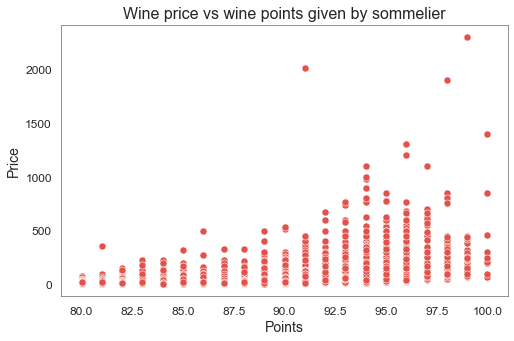

In [17]:
params_dict = \
    {'figure.figsize':(8,5),
     'axes.labelsize': 14.0,
     'xtick.labelsize': 12.0,
     'ytick.labelsize': 12.0,
     'lines.linewidth': 2,
     'axes.linewidth': 0.5,
     'grid.linewidth': 1,
 }
sns.set_theme(rc=params_dict, style='white', palette='Spectral')
sns.scatterplot(data=data, x=points, y=price, s=50)
plt.xlabel("Points")
plt.ylabel("Price")
plt.title("Wine price vs wine points given by sommelier", size=16)


Based on this plot, it is hard to say whether there is link between wine score and price.

The below a 2 histograms for wine prices: one for original prices and one for prices after computing logarithm with base 10. This is a common transformation applied to skewed data to make it closer to "bell shaped" and it preserves original relationships and patterns in data. As can be seen the original data is indeed very skewed, but log-transformation makes it much more "normal". For future data analysis it might be more appropriate to use this log-transformed data instead, but for now let's look into original prices little more.

Text(0.5, 1.0, 'Histogram of wine prices on log-scale')

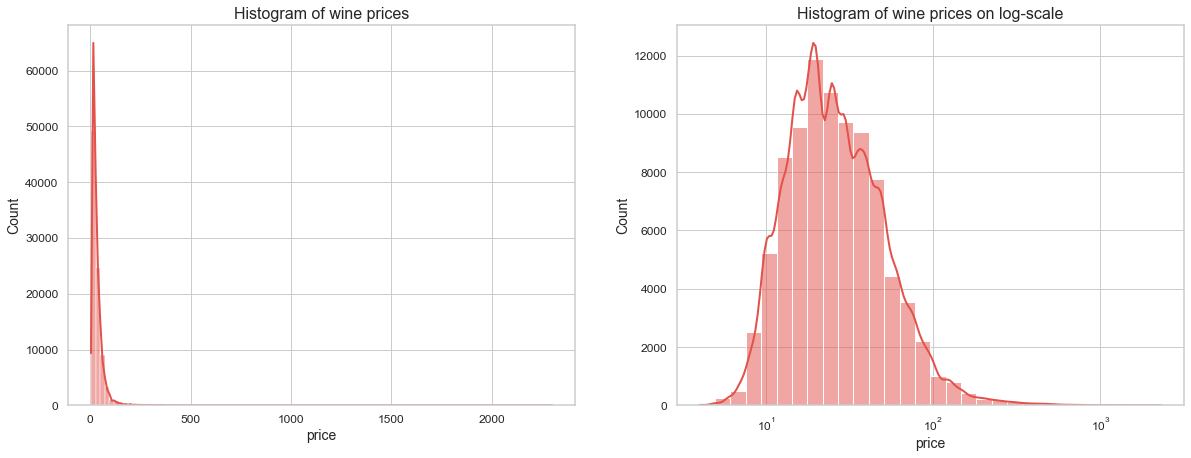

In [43]:
params_dict = \
    {'figure.figsize':(10,7),
     'axes.labelsize': 14.0,
     'xtick.labelsize': 12.0,
     'ytick.labelsize': 12.0,
     'lines.linewidth': 2,
     'axes.linewidth': 1.5,
     'grid.linewidth': 1,
 }
sns.set_theme(rc=params_dict, style='whitegrid', palette='Spectral')
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.histplot(data, x=price, kde=True, bins=100, ax=ax[0])
ax[0].set_title("Histogram of wine prices", size=16)

sns.histplot(data, x=price, kde=True, bins=30, ax=ax[1], log_scale=True)
ax[1].set_title("Histogram of wine prices on log-scale", size=16)

Let's plots some boxplots of wine prices per points group, just to see what we are dealing with. While doing this also calculate some descriptive statistics including medians, which will be used for replacement.

Prices for scores from 80 to 84
Group size: 13996 observations
Mean: 18.78
Median: 15.00
Standard deviation: 12.61
Min: 4.00
Max: 354.00


Prices for scores from 85 to 89
Group size: 46488 observations
Mean: 25.58
Median: 20.00
Standard deviation: 17.55
Min: 4.00
Max: 500.00


Prices for scores from 90 to 94
Group size: 27015 observations
Mean: 49.24
Median: 40.00
Standard deviation: 41.25
Min: 5.00
Max: 2013.00


Prices for scores from 95 to 100
Group size: 1632 observations
Mean: 133.40
Median: 85.00
Standard deviation: 146.59
Min: 20.00
Max: 2300.00




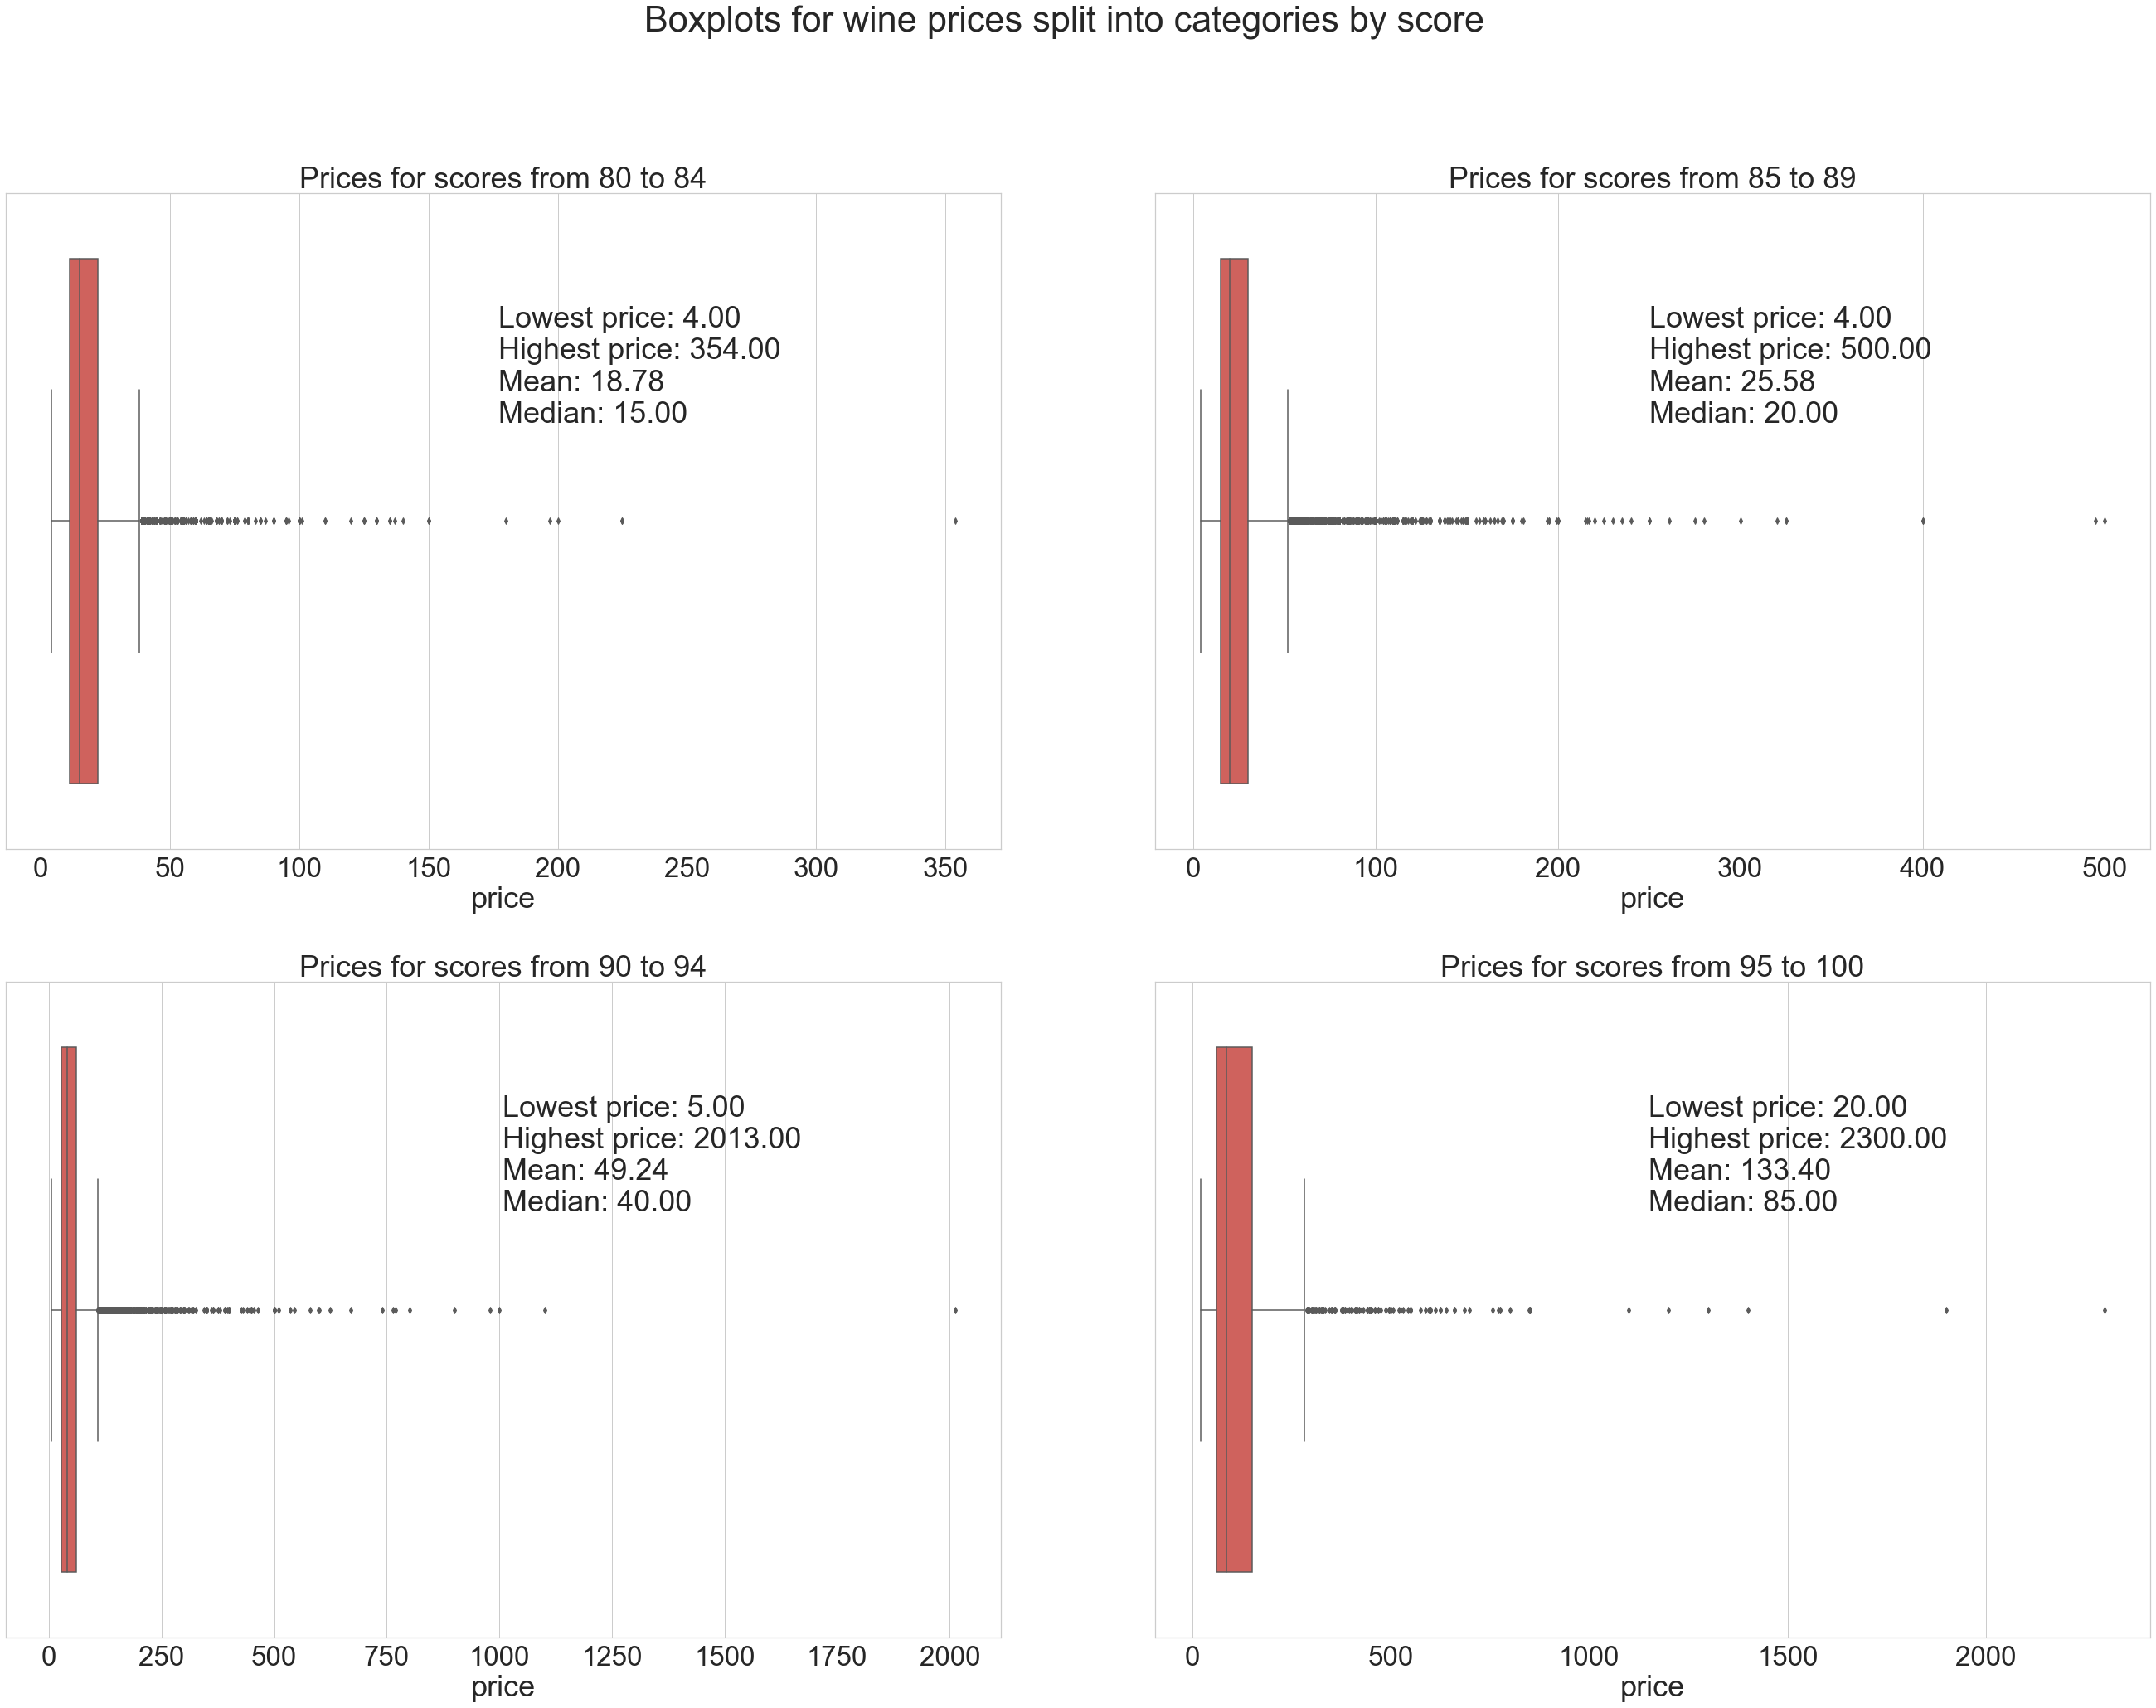

In [44]:
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=3)

fig, ax = plt.subplots(rows, cols, figsize=(40, 30))
fig.suptitle("Boxplots for wine prices split into categories by score")#, size=32)
fig.tight_layout(pad=3)

data_to_replace_nulls = []

coord_generator = get_row_and_column_index(rows, cols)
for i, (bottom, top) in enumerate(ranges):   
    bottom += min_points
    top += min_points
    if i == len(ranges)-1:
        top += 1
    subset = data[data[points].isin(range(bottom, top))]
    subset = subset[~subset[price].isna()]
    
    stats = subset[price].describe()
    mean = stats['mean']   
    median = stats['50%']
    max_price = stats['max']
    min_price = stats['min']
    std = stats['std']
    
    data_to_replace_nulls.append(((range(bottom, top)), median))
        
    print(f"Prices for scores from {bottom} to {top-1}")
    print(f"Group size: {len(subset)} observations")
    print("Mean: {0:.2f}".format(mean))
    print("Median: {0:.2f}".format(median))
    print("Standard deviation: {0:.2f}".format(std))
    print("Min: {0:.2f}".format(min_price))
    print("Max: {0:.2f}".format(max_price))
    print('\n')
    coord = next(coord_generator)
    sns.boxplot(x=subset[price], ax=ax[coord[0], coord[1]])
    ax[coord[0], coord[1]].set_title(f"Prices for scores from {bottom} to {top-1}")#, size=44)
    ax[coord[0], coord[1]].text(max_price - max_price/2, -0.15,
                                "Lowest price: {:.2f}\nHighest price: {:.2f}\nMean: {:.2f}\nMedian: {:.2f}".format(min_price, max_price, mean, median))

By looking onto these plots, we can say that the data in each group is quite skewed, so has outliers, i.e. unusally pricy bottles of wine for a particular group. This can also confirmed by the fact that means and medians are not equal. Also, we can say that the range of prices tends to get bigger the higher the score. This is reflected in groups maximum price, which gets higher and also mean and median prices get substantially higher too. However, apart from the last group with the highest scores, the rest have pretty much same starting price. From these plots it is not completely clear if the prices majority per group are that much different.

#### Dealing with missing values and adding new columns

In [45]:
# replace missing prices with median
for range_, replacement in data_to_replace_nulls:
    subset = data[data[points].isin(range_)]
    subset = subset[~subset[price].isna()]
    mask = data[points].isin(range_) & data[price].isna()
    data[price].mask(mask, replacement, inplace=True)
    
# drop the rest of missing values that by this point should be 3 examples with missing countries
data.dropna(inplace=True)

For future analysis need to create a new column that will have score group name and another column with log base 10 of wine prices.

In [47]:
for range_, _ in data_to_replace_nulls:
    group_string = f"{range_[0]} to {range_[-1]}"
    mask = data[points].isin(range_) 
    data.loc[mask, points_group] = group_string
data[log10_price] = np.log10(data[price])
    
print(data.head())

  country                                        description  points  price  \
0      US  This tremendous 100% varietal wine hails from ...      96  235.0   
1   Spain  Ripe aromas of fig, blackberry and cassis are ...      96  110.0   
2      US  Mac Watson honors the memory of a wine once ma...      96   90.0   
3      US  This spent 20 months in 30% new French oak, an...      96   65.0   
4  France  This is the top wine from La Bégude, named aft...      95   66.0   

              variety points_group  log10_price  
0  Cabernet Sauvignon    95 to 100     2.371068  
1       Tinta de Toro    95 to 100     2.041393  
2     Sauvignon Blanc    95 to 100     1.954243  
3          Pinot Noir    95 to 100     1.812913  
4  Provence red blend    95 to 100     1.819544  


Let's insure that there are no missing values now.

In [49]:
for column_name in required_columns:
    column = data[[column_name]]
    na_values = column.isna().sum(axis=0)[column_name]
    print(f"Column '{column_name}' has {na_values} missing values.")
    
print(len(data))

Column 'country' has 0 missing values.
Column 'description' has 0 missing values.
Column 'points' has 0 missing values.
Column 'price' has 0 missing values.
Column 'variety' has 0 missing values.
97848


### ANOVA

Since it wasn't entirely obvious whether there is a significant difference between wine groups (and in general making conclusions about data by only looking at sample plots isn't right) we'll performs an ANOVA (Analysis of Variance) on prices vs score groups. For ANOVA results to be interpretable, the groups have to follow normal distribution, hence need to use log-transformed data.

Checking sizes of groups, can note that they are not equal, but it still should be fine as long as they approximately normally distributed. And since distribution of all prices (log-transformed) is approximatelly normal, distribution in groups is normal too.

In [52]:
data[points_group] = ''

for range_, _ in data_to_replace_nulls:
    group_string = f"{range_[0]} to {range_[-1]}"
    subset = data[data[points].isin(range_)]   
    data[points_group].mask(data[points].isin(range_), group_string, inplace=True)
    print(f"Group {group_string} points has {len(subset)} observations")

Group 80 to 84 points has 14624 observations
Group 85 to 89 points has 50939 observations
Group 90 to 94 points has 30373 observations
Group 95 to 100 points has 1912 observations


In [63]:
print("LOG PRICE")
model = ols(f'log10_price ~ C({points_group})', data=data).fit()
anova_table_log = sm.stats.anova_lm(model, typ=2)
print(anova_table_log)


print('\n')
print("ORIGINAL PRICE")
model = ols(f'{price} ~ C({points_group})', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)


LOG PRICE
                      sum_sq       df             F  PR(>F)
C(points_group)  2732.322989      3.0  17801.096322     0.0
Residual         5006.085125  97844.0           NaN     NaN


ORIGINAL PRICE
                       sum_sq       df            F  PR(>F)
C(points_group)  2.988615e+07      3.0  9895.588729     0.0
Residual         9.850116e+07  97844.0          NaN     NaN


In [62]:
res = stat()
res.tukey_hsd(df=data, res_var=price, xfac_var=points_group, anova_model=f'{price} ~ C({points_group})')
res.tukey_summary

C:\Users\user\anaconda3\envs\data_analysis_env\lib\site-packages\bioinfokit\analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,95 to 100,90 to 94,78.093118,76.171175,80.015061,147.625570,0.001
1,95 to 100,85 to 89,101.220578,99.321752,103.119405,193.674656,0.001
2,95 to 100,80 to 84,107.694346,105.712062,109.676631,197.385905,0.001
3,90 to 94,85 to 89,23.127460,22.536530,23.718390,142.193946,0.001
4,90 to 94,80 to 84,29.601228,28.780796,30.421660,131.086002,0.001
5,85 to 89,80 to 84,6.473768,5.709054,7.238482,30.757246,0.001


In [69]:
res_log = stat()
res_log.tukey_hsd(df=data, res_var='log10_price', xfac_var=points_group, anova_model=f'log10_price ~ C({points_group})')
res_log.tukey_summary

C:\Users\user\anaconda3\envs\data_analysis_env\lib\site-packages\bioinfokit\analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


,group1,group2,Diff,Lower,Upper,q-value,p-value
0,95 to 100,90 to 94,0.374866,0.361165,0.388568,99.402362,0.001
1,95 to 100,85 to 89,0.650086,0.636549,0.663622,174.480214,0.001
2,95 to 100,80 to 84,0.777223,0.763091,0.791355,199.820728,0.001
3,90 to 94,85 to 89,0.275220,0.271007,0.279432,237.358044,0.001
4,90 to 94,80 to 84,0.402357,0.396508,0.408206,249.936482,0.001
5,85 to 89,80 to 84,0.127137,0.121686,0.132589,84.729629,0.001


Text(0, 0.5, 'Frequency')

<Figure size 720x504 with 0 Axes>

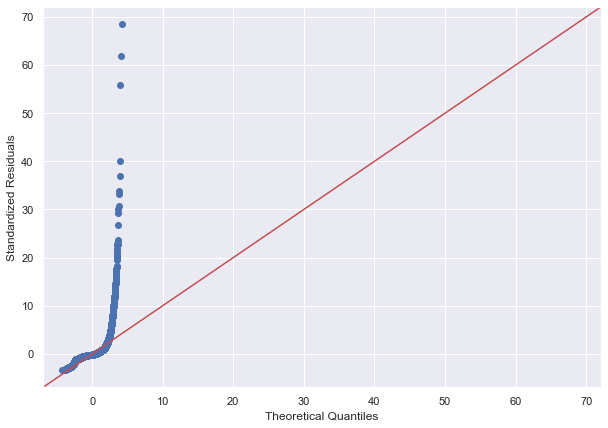

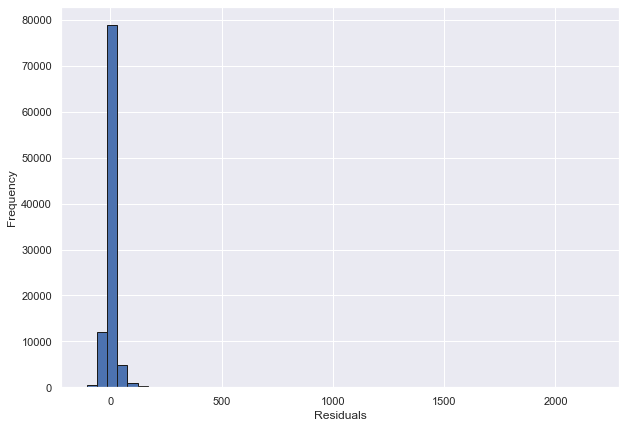

In [64]:
sns.set_theme()
fig = plt.figure()
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")

fig = plt.figure()
plt.hist(res.anova_model_out.resid, bins=50, histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

<Figure size 720x504 with 0 Axes>

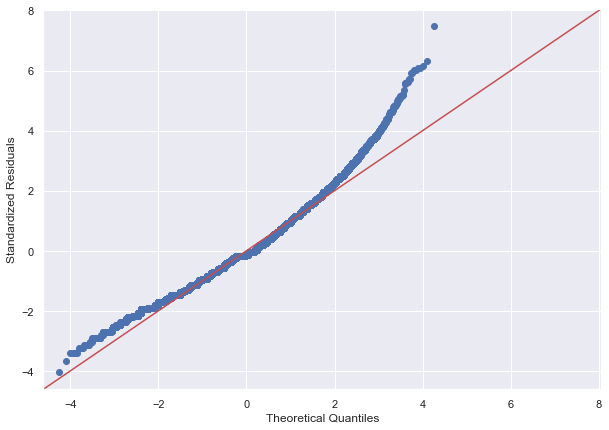

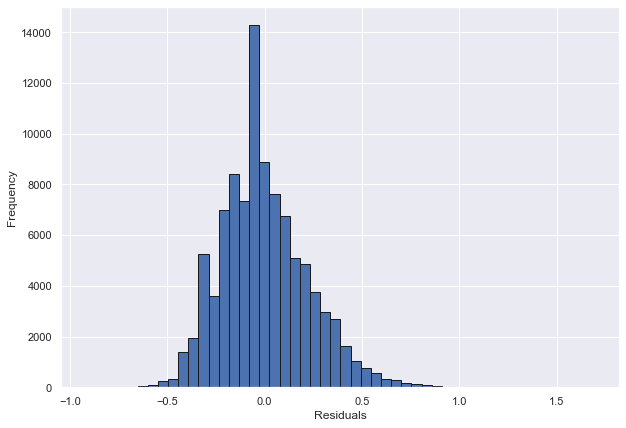

In [70]:
sns.set_theme()
fig = plt.figure()
sm.qqplot(res_log.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")

fig = plt.figure()
plt.hist(res_log.anova_model_out.resid, bins=50, histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')

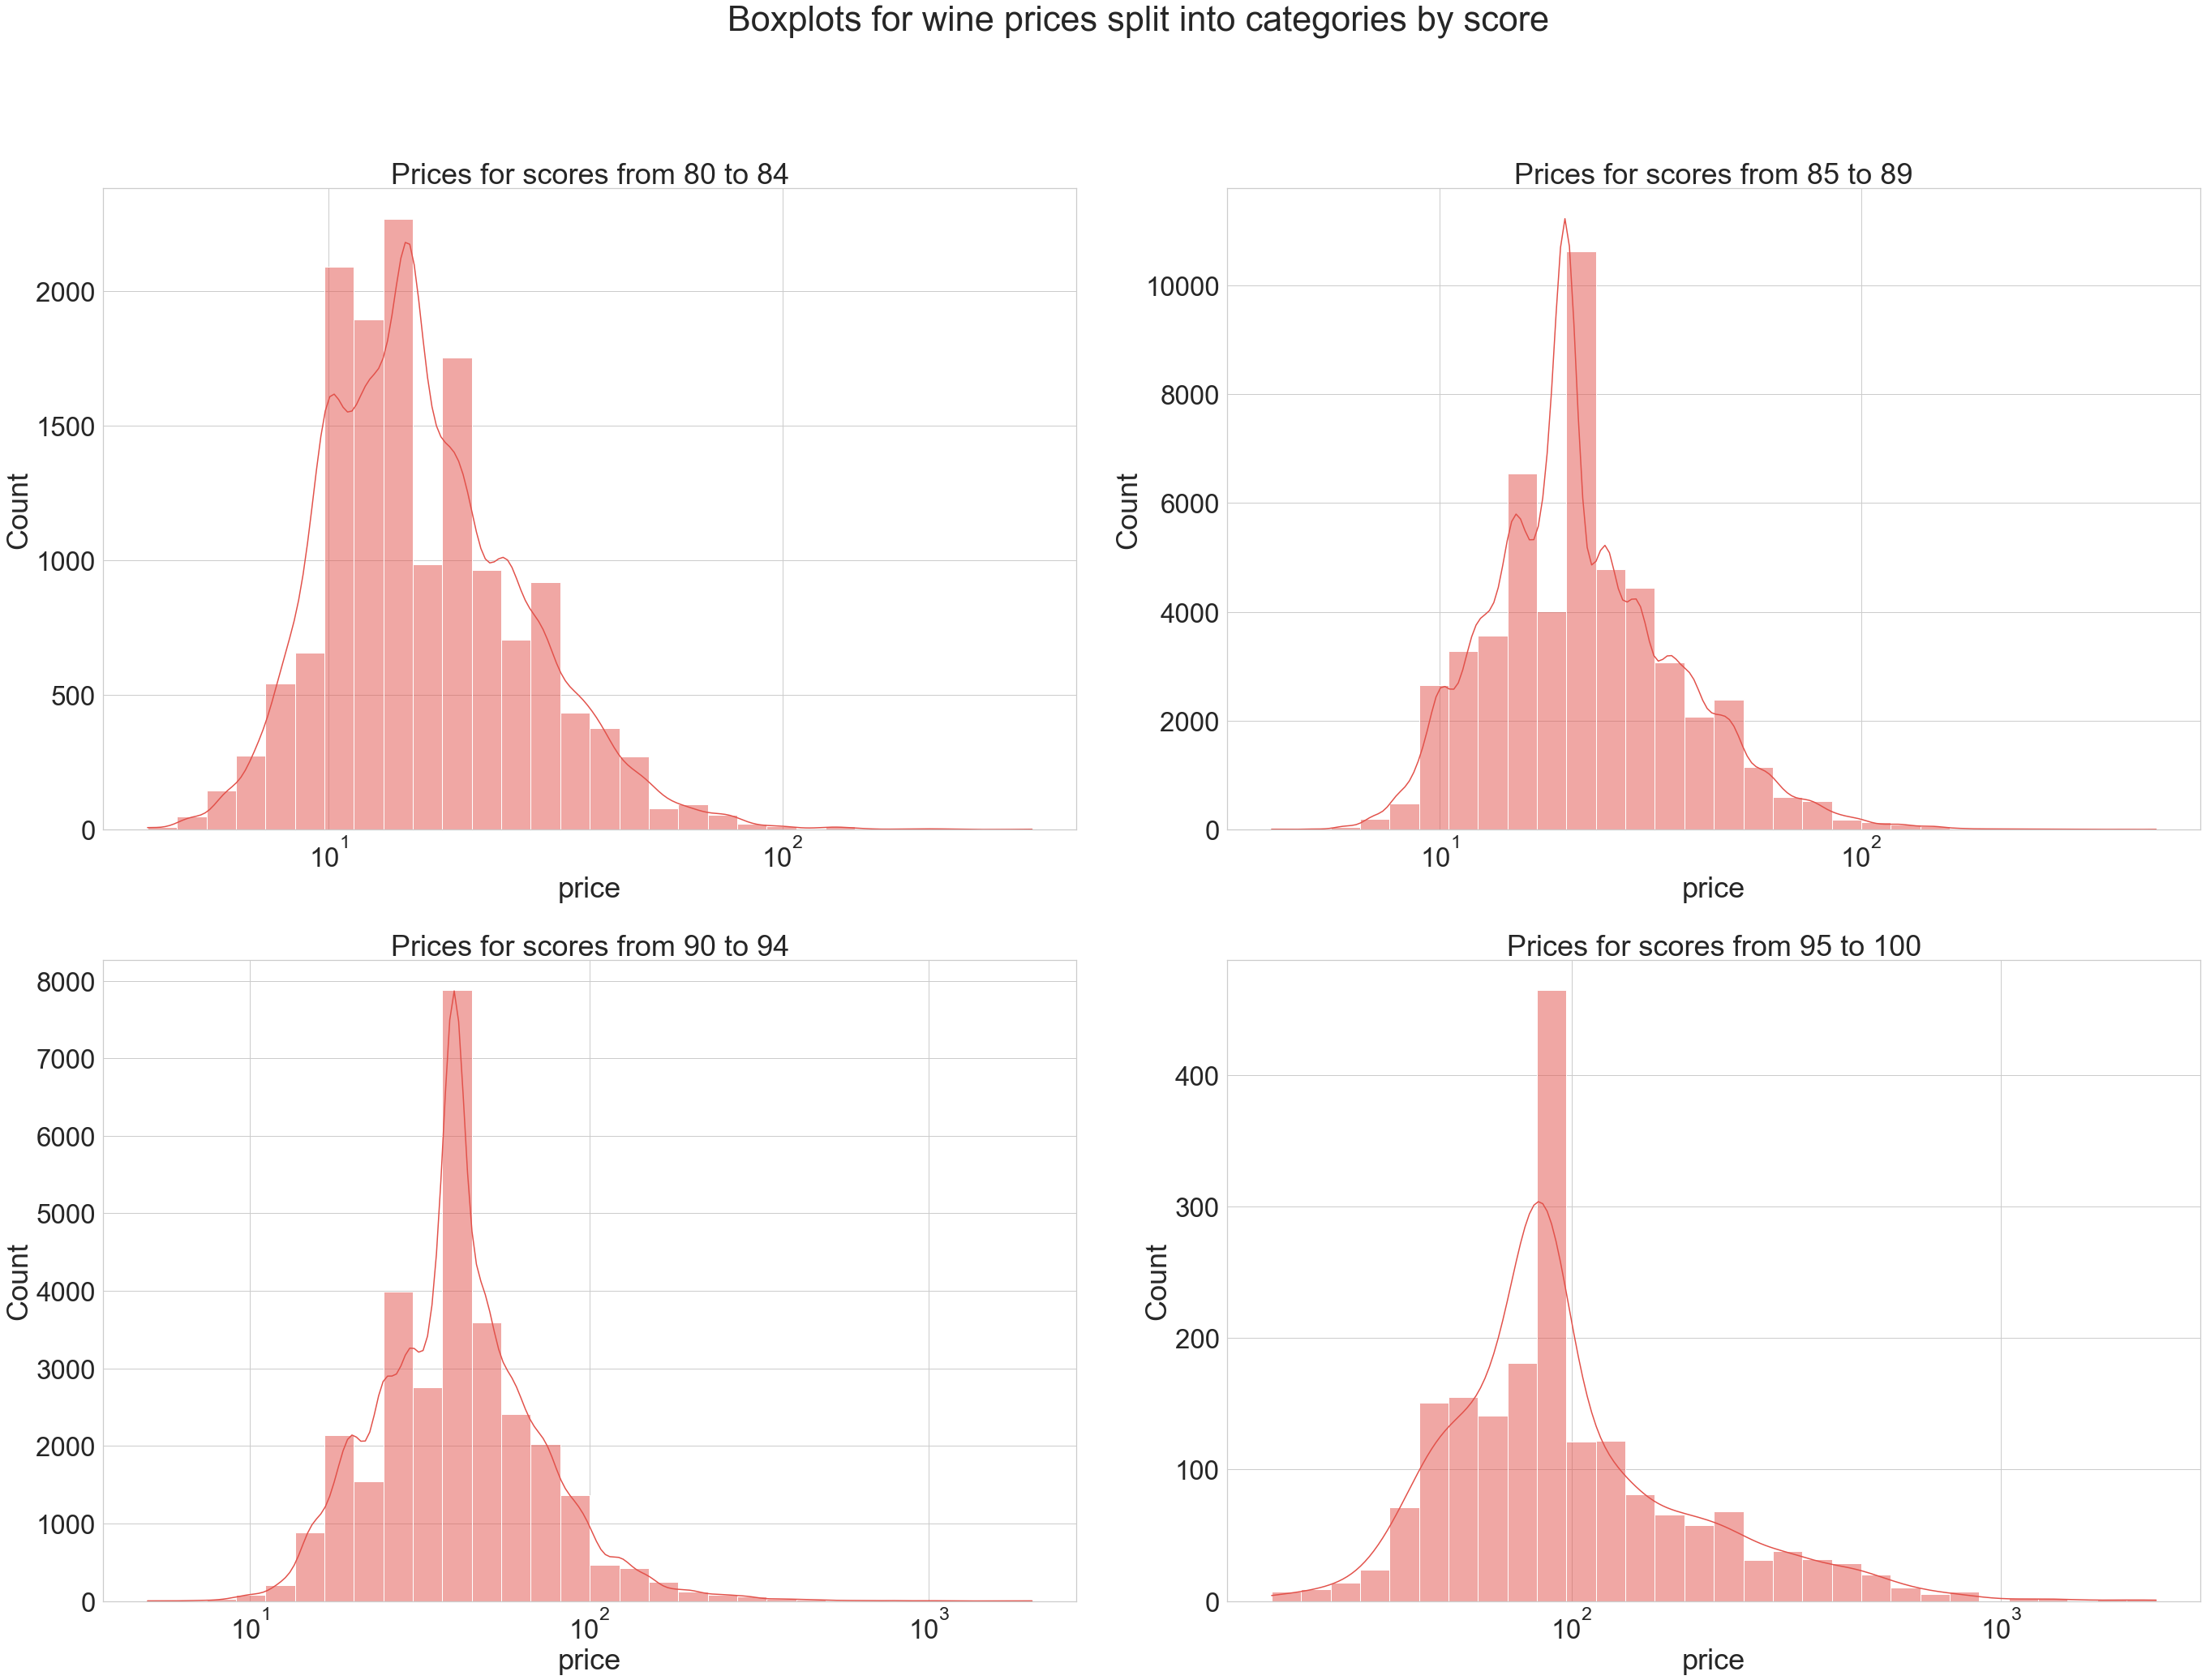

In [60]:
# sns.set_context("poster", font_scale = 2)
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=3)
# sns.set_style('whitegrid')

fig, ax = plt.subplots(rows, cols, figsize=(40, 30))
fig.suptitle("Boxplots for wine prices split into categories by score")#, size=32)
fig.tight_layout(pad=3)

coord_generator = get_row_and_column_index(rows, cols)
for i, (bottom, top) in enumerate(ranges):   
    bottom += min_points
    top += min_points
    if i == len(ranges)-1:
        top += 1
    subset = data[data[points].isin(range(bottom, top))]
    coord = next(coord_generator)
    sns.histplot(subset, x=price, log_scale=True, kde=True, bins=30, ax=ax[coord[0], coord[1]])
    ax[coord[0], coord[1]].set_title(f"Prices for scores from {bottom} to {top-1}")#, size=44)
    

In [58]:
print(ranges)

[(0, 5), (5, 10), (10, 15), (15, 20)]


In [ ]:
# TODO
# write some text
# deal with plots
# analysis
    # price correlates with points?
    # overall price analysis
    # where is the best wine?
    # where is the most expensive wine?
    # what wine is cheap but has high score? what are the descrition?
    # what wine is expensive but has low score?
    #ANOVA
# nlp
    # is it possible to predict score from description?
    # what are most common words?/per wine category?
    # sweet-savory cart?
    # word clouds
    

In [ ]:
(data[country].value_counts())
(len(data[variety].unique()))

In [ ]:
sns.plotting_context()
